## Zestaw 2

### Zadanie 1

A. Załadowanie, wyświetlenie obrazu, zapis do pliku, wypisanie infomracji o obrazie (format, tryb koloru, rozmiar), zmiana rozmiaru, operacje: obrót, odwrócenie, wycinek; przygotowanie obrazu do sieci neuronowej: skalowanie, centrowanie, standaryzacja, itp.

In [1]:
import requests
from PIL import Image, ImageOps
from io import BytesIO
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam


In [2]:
# Url do obrazu
url = 'https://zwierzakinadpotokiem.pl/wp-content/uploads/2024/01/dog-7021171_1280-min.jpg'

# Pobranie obrazu z URL
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img_second = Image.open(BytesIO(response.content))

# Wyświetlenie obrazu
img.show()

# Zapisanie obrazu do pliku
img.save('downloaded_dog_image.jpg')

# Wyświetlenie informacji o obrazie (format, tryb koloru, rozmiar)
print(f"Format: {img.format}")
print(f"Tryb koloru: {img.mode}")
print(f"Rozmiar: {img.size}")

Format: JPEG
Tryb koloru: RGB
Rozmiar: (1280, 1024)


In [3]:
# Zmiana rozmiaru np na 500 x 700
resized_image = img.resize((500, 700))
resized_image.show()

# Obrót obrazu
rotated_image = img.rotate(90)
rotated_image.show()

# Obrót obrazu z zachowaniem rozmiaru
flipped_image = ImageOps.flip(img)
flipped_image.show()

# Wycinek obrazu
cropped_image = img.crop((0, 0, 200, 200))
cropped_image.show()

# Przygotowanie obrazu do sieci neuronowej
def preprocess_image(image_path, target_size=(224, 224)):
    # Załaduj obraz
    img = Image.open(image_path)

    # Zmiana rozmiaru obrazu (do rozmiaru wymaganego przez model, np. 224x224)
    img = img.resize(target_size)

    # Konwersja obrazu do macierzy numpy
    img_array = np.array(img)

    # Skalowanie wartości pikseli do zakresu [0, 1]
    img_array = img_array / 255.0

    # Centrowanie (odejmowanie średniej)
    mean = np.mean(img_array, axis=(0, 1, 2), keepdims=True)  # Obliczamy średnią dla każdego kanału
    img_array -= mean

    # Standaryzacja (dzielenie przez odchylenie standardowe)
    std = np.std(img_array, axis=(0, 1, 2), keepdims=True)  # Obliczamy odchylenie standardowe
    img_array /= std

    # Dodanie wymiaru dla batcha (jeśli wymagane przez sieć)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

# Przykład użycia funkcji preprocess_image
image_path = 'downloaded_dog_image.jpg'
preprocessed_image = preprocess_image(image_path)

# Wyświetlenie przygotowanego obrazu
print(preprocessed_image.shape)

(1, 224, 224, 3)


B. Ładuje i wizualizuje obraz, wykonuje na obrazie konwolucję zadanym filtrem (lub zestawem filtrów), na koniec wizualizuje i zapisuje obraz wynikowy do pliku. Filtry zapisać jako macierze kwadratowe o nieparzystej długości boku. Jeśli filtr da się zadawać analitycznie, dodatkowym parametrem wywołania powinien być rozmiar. Obraz wynikowy powinien być tej samej wielkości, co obraz wejściowy.

![Zrzut ekranu 2024-10-26 100951.png](<attachment:Zrzut ekranu 2024-10-26 100951.png>)
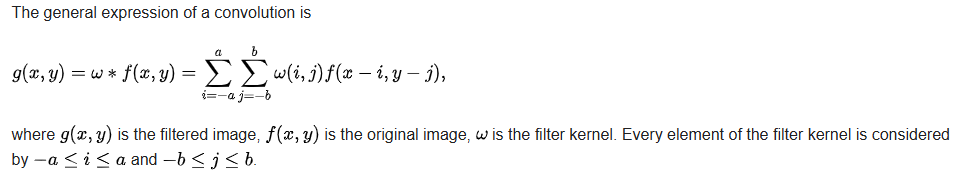

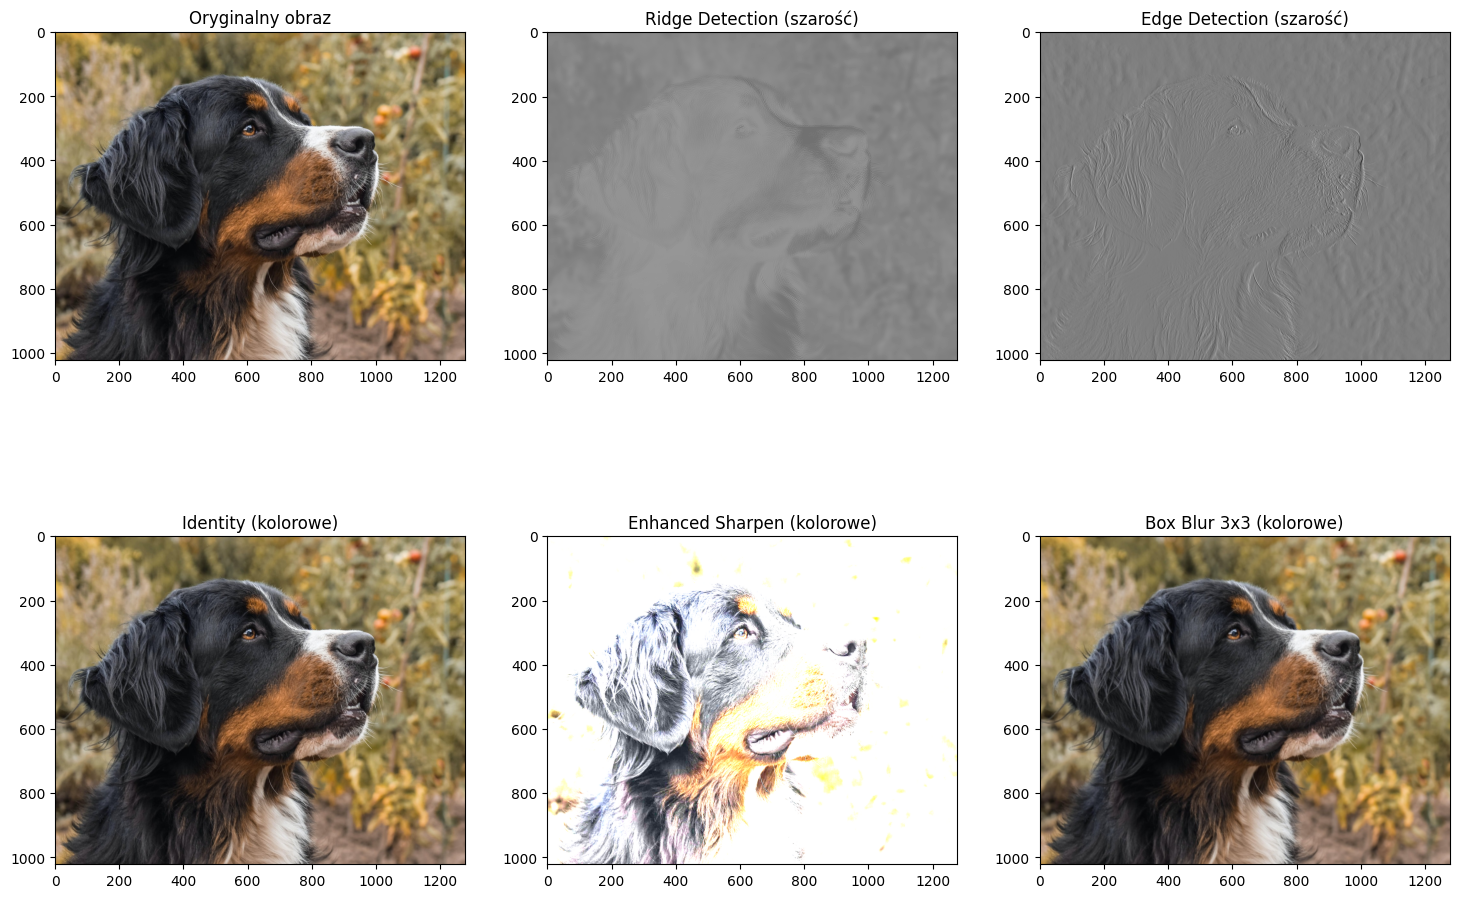

In [4]:
# Przygotowanie obrazu
img = np.array(img)  # Przekształcenie obrazu na tablicę numpy
# Przygotowanie obrazu do tensoru i normalizacja
image_color = torch.Tensor(img) / 255.0  # Konwersja obrazu do tensora i normalizacja
image_color = image_color.permute(2, 0, 1).unsqueeze(0)  # Przekształcenie na format (1, 3, H, W)

# Filtry detekcji krawędzi (szarość)
ridge_detection_kernel = torch.Tensor([[-1, -1, -1],
                                       [-1,  7, -1],
                                       [-1, -1, -1]]).view(1, 1, 3, 3)  # Zmodyfikowany kernel dla lepszej detekcji

edge_detection_kernel = torch.Tensor([[1, 0, -1],
                                      [1, 0, -1],
                                      [1, 0, -1]]).view(1, 1, 3, 3)

# Kolorowe filtry (zachowujące oryginalny kolor)
identity_kernel = torch.Tensor([[0, 0, 0],
                                [0, 1, 0],
                                [0, 0, 0]]).view(1, 1, 3, 3).repeat(3, 1, 1, 1)

# Zwiększony efekt Sharpen
sharpen_kernel = torch.Tensor([[0, -1, 0],
                               [-1, 9, -1],
                               [0, -1, 0]]).view(1, 1, 3, 3).repeat(3, 1, 1, 1)

# Box blur
box_blur_kernel = torch.Tensor([[1, 1, 1],
                                [1, 1, 1],
                                [1, 1, 1]]) / 9.0
box_blur_kernel = box_blur_kernel.view(1, 1, 3, 3).repeat(3, 1, 1, 1)

# Gaussian blur dla porównania
gaussian_blur_kernel = torch.Tensor([[1, 2, 1],
                                     [2, 4, 2],
                                     [1, 2, 1]]) / 16.0
gaussian_blur_kernel = gaussian_blur_kernel.view(1, 1, 3, 3).repeat(3, 1, 1, 1)

# Zastosowanie filtrów do obrazu szarości i kolorowych
ridge_detection = F.conv2d(image_color.mean(dim=1, keepdim=True), ridge_detection_kernel)
edge_detection = F.conv2d(image_color.mean(dim=1, keepdim=True), edge_detection_kernel)

identity_img = F.conv2d(image_color, identity_kernel, groups=3)
sharpen_img = F.conv2d(image_color, sharpen_kernel, groups=3)
box_blur_img = F.conv2d(image_color, box_blur_kernel, groups=3)
gaussian_blur_img = F.conv2d(image_color, gaussian_blur_kernel, groups=3)

# Rysowanie wynikowych obrazów
fig, ax = plt.subplots(2, 3, figsize=(18, 12))

# Oryginalny obraz
ax[0, 0].imshow(img)
ax[0, 0].set_title('Oryginalny obraz')

# Filtry w skali szarości
ax[0, 1].imshow(ridge_detection.squeeze(), cmap='gray')
ax[0, 1].set_title('Ridge Detection (szarość)')

ax[0, 2].imshow(edge_detection.squeeze(), cmap='gray')
ax[0, 2].set_title('Edge Detection (szarość)')

# Filtry kolorowe
ax[1, 0].imshow(identity_img.squeeze().clamp(0, 1).permute(1, 2, 0).numpy())
ax[1, 0].set_title("Identity (kolorowe)")

ax[1, 1].imshow(sharpen_img.squeeze().clamp(0, 1).permute(1, 2, 0).numpy())
ax[1, 1].set_title("Enhanced Sharpen (kolorowe)")

ax[1, 2].imshow(box_blur_img.squeeze().clamp(0, 1).permute(1, 2, 0).numpy())
ax[1, 2].set_title("Box Blur 3x3 (kolorowe)")

plt.show()

# Zapisanie wynikowych obrazów do plików
plt.imsave('ridge_detection.jpg', ridge_detection.squeeze().numpy(), cmap='gray')
plt.imsave('edge_detection.jpg', edge_detection.squeeze().numpy(), cmap='gray')
plt.imsave('identity_img.jpg', identity_img.squeeze().clamp(0, 1).permute(1, 2, 0).numpy())
plt.imsave('sharpen_img.jpg', sharpen_img.squeeze().clamp(0, 1).permute(1, 2, 0).numpy())
plt.imsave('box_blur_img.jpg', box_blur_img.squeeze().clamp(0, 1).permute(1, 2, 0).numpy())
plt.imsave('gaussian_blur_img.jpg', gaussian_blur_img.squeeze().clamp(0, 1).permute(1, 2, 0).numpy())

C. Zademonstrować w kodzie działanie konwolucji jako metody. Uwzględnić hiperparametry: Stride (S), 0-Padding (P), rozmiar maski filtru (F). Przy wybranym F i S algorytm ma sam ustalić najmniejsze P, tak, aby obraz wynikowy miał ten sam rozmiar, co wejściowy.
Do kodu dołączyć obraz/y wejściowe użyte w kodzie.

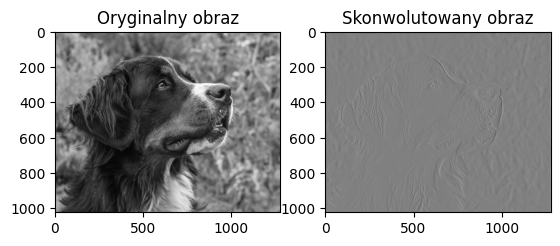

In [12]:
def apply_convolution(image_array, kernel, stride=1):

    # Automatyczne wyliczenie paddingu
    padding = ((stride - 1) * image_array.shape[0] - stride + kernel.shape[0]) // 2
    # Dodaj padding do obrazu
    padded_image = np.pad(image_array, ((padding, padding), (padding, padding)), 'constant')

    # Rozmiary obrazu wejściowego po paddingu
    height, width = padded_image.shape

    # Inicjalizujemy pustą macierz dla obrazu wynikowego
    output_height = (height - kernel.shape[0]) // stride + 1
    output_width = (width - kernel.shape[1]) // stride + 1
    output_image = np.zeros((output_height, output_width))

    # STRIDE S - dystans pomiędzy kolejnymi oknami konwolucyjnymi np. S=1 -> przesuwamy o 1 piksel, dla S=2 -> przesuwamy o 2 piksele
    # Przesuwanie okna konwolucyjnego -> przesuwamy zgodnie z wartością stride
    for i in range(0, output_height, stride):
        for j in range(0, output_width, stride):
            region = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            output_image[i, j] = np.sum(region * kernel)

    return output_image

# Załaduj obraz i skonwertuj go do skali szarości -> redukcja do 1 kanału
image = img_second.convert('L')
image_array = np.array(image)

# Definiujemy filtr (np. detekcja krawędzi)
kernel = np.array([[1, 0, -1], 
                   [1, 0, -1], 
                   [1, 0, -1]])

# Zastosowanie konwolucji
convolved_image = apply_convolution(image_array, kernel, stride=1)

# Przeskalowuje wartości pikseli do zakresu [0, 255], co sprawia, że wynikowy obraz jest odpowiednio sformatowany do wyświetlenia w odcieniach szarości.
convolved_image = (convolved_image - np.min(convolved_image)) / (np.max(convolved_image) - np.min(convolved_image)) * 255
convolved_image = convolved_image.astype(np.uint8)

# Wyświetlenie oryginalnego i wynikowego obrazu
plt.subplot(1, 2, 1)
plt.imshow(image_array, cmap='gray')
plt.title('Oryginalny obraz')

plt.subplot(1, 2, 2)
plt.imshow(convolved_image, cmap='gray')
plt.title('Skonwolutowany obraz')

plt.show()

### Zadanie 2

Klasa ImageDataGenerator z biblioteki Keras. Jest to automat do „tworzenia” dodatkowych obrazów. Jak używać tego generatora podczas uczenia?
- Data augmentation (rozszerzenie danych) to technika używana w uczeniu modeli sieci neuronowych, zwłaszcza w przypadku sieci konwolucyjnych (CNN), aby zwiększyć rozmiar zbioru danych poprzez generowanie nowych obrazów z istniejących. Pozwala to na tworzenie dodatkowych próbek poprzez różne transformacje, takie jak rotacje, skalowanie, przycinanie, odwrócenie itp. Technika ta pomaga uniknąć nadmiernego dopasowania (overfitting) i poprawia zdolność modelu do generalizacji.

Epoch 1/5
1562/1562 [==============================] - 27s 17ms/step - loss: 4.1355 - accuracy: 0.0738 - val_loss: 1.8155 - val_accuracy: 0.0874
Epoch 2/5
1562/1562 [==============================] - 27s 17ms/step - loss: 1.8201 - accuracy: 0.1043 - val_loss: 1.6703 - val_accuracy: 0.0830
Epoch 3/5
1562/1562 [==============================] - 30s 19ms/step - loss: 1.7233 - accuracy: 0.1132 - val_loss: 1.6089 - val_accuracy: 0.0766
Epoch 4/5
1562/1562 [==============================] - 30s 19ms/step - loss: 1.6622 - accuracy: 0.1148 - val_loss: 1.5989 - val_accuracy: 0.1419
Epoch 5/5
1562/1562 [==============================] - 30s 19ms/step - loss: 1.6151 - accuracy: 0.1186 - val_loss: 1.5078 - val_accuracy: 0.0837


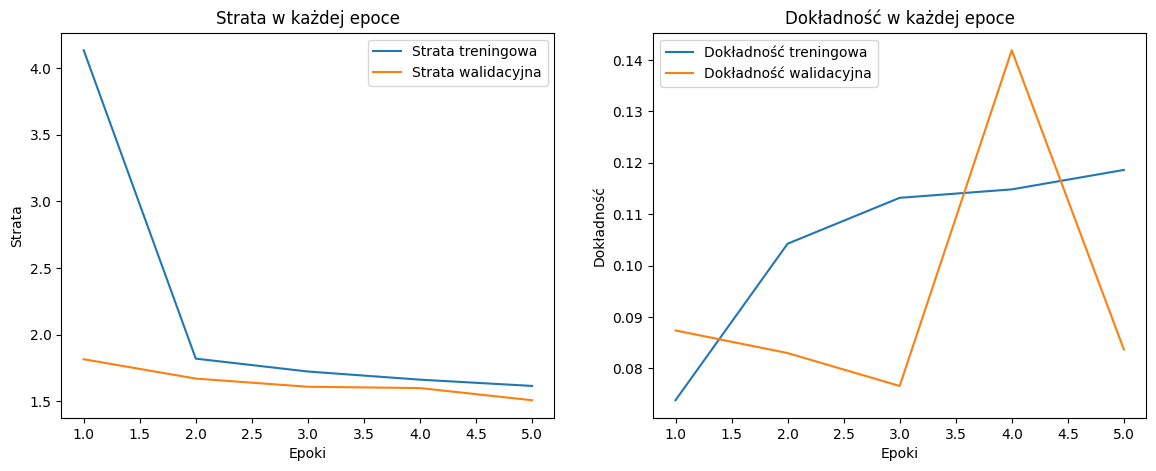

In [14]:
# Inicjalizacja klasy ImageDataGenerator z różnymi transformacjami
datagen = ImageDataGenerator(
    rotation_range=40,        # Losowe rotacje do 40 stopni
    width_shift_range=0.2,    # Losowe przesunięcie w poziomie do 20% szerokości
    height_shift_range=0.2,   # Losowe przesunięcie w pionie do 20% wysokości
    shear_range=0.2,          # Losowe ścinanie obrazu
    zoom_range=0.2,           # Losowe przybliżenie
    horizontal_flip=True,     # Losowe odwrócenie w poziomie
    fill_mode='nearest'       # Metoda wypełniania pikseli po transformacjach
)

# CIFAR-10 to zbiór danych zawierający 60 000 kolorowych obrazów o rozmiarze 32x32 pikseli, podzielonych na 10 klas.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Tworzenie instancji ImageDataGenerator z augmentacją
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Przykład modelu CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Kompilacja modelu
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    steps_per_epoch=len(X_train) // 32, epochs=5, 
                    validation_data=(X_test, y_test))

# Rysowanie wykresu strat i dokładności
epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(14, 5))

# Wykres funkcji straty
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Strata treningowa')
plt.plot(epochs, history.history['val_loss'], label='Strata walidacyjna')
plt.title('Strata w każdej epoce')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Dokładność treningowa')
plt.plot(epochs, history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność w każdej epoce')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

plt.show()

### Zadanie 3

Sieć CNN
- Warstwa splotowa Conv2D - splot obrazu wejściowego za pomocą zestawu filtrów (przesuwając filtr tzw. kernel), aby utworzyć zestaw tzw. map cech.
- Warstwa MaxPooling2D - zmniejszenie wymiarowości map cech, aby zmniejszyć liczbę parametrów i obliczeń w sieci. Najczęściej stosowany max pooling, czyli wybieranie maksymalnej wartości z okna o określonym rozmiarze.
- Warstwa BatchNormalization - normalizacja wsadowa, czyli normalizacja wartości wejściowych do warstwy poprzez obliczenie średniej i odchylenia standardowego wsadowo.
- Dropout - technika regularyzacji, polegająca na losowym wyłączaniu pewnej liczby neuronów w warstwie podczas treningu, pomaga uniknąć przeuczenia sieci.
- Hiperparametry sieci CNN: Stride (przesunięcie filtra), Padding (dodanie pikseli wokół obrazu), liczba filtrów, rozmiar filtra, funkcja aktywacji, itp.

Epoch 1/10
782/782 [==============================] - 34s 42ms/step - loss: 1.7715 - accuracy: 0.3597 - val_loss: 1.5245 - val_accuracy: 0.4782
Epoch 2/10
782/782 [==============================] - 31s 40ms/step - loss: 1.4549 - accuracy: 0.4767 - val_loss: 1.1744 - val_accuracy: 0.5869
Epoch 3/10
782/782 [==============================] - 32s 41ms/step - loss: 1.3166 - accuracy: 0.5321 - val_loss: 1.1704 - val_accuracy: 0.5943
Epoch 4/10
782/782 [==============================] - 33s 42ms/step - loss: 1.2211 - accuracy: 0.5674 - val_loss: 1.0487 - val_accuracy: 0.6362
Epoch 5/10
782/782 [==============================] - 32s 41ms/step - loss: 1.1484 - accuracy: 0.5992 - val_loss: 0.9787 - val_accuracy: 0.6485
Epoch 6/10
782/782 [==============================] - 35s 45ms/step - loss: 1.0925 - accuracy: 0.6186 - val_loss: 1.1121 - val_accuracy: 0.6184
Epoch 7/10
782/782 [==============================] - 38s 48ms/step - loss: 1.0502 - accuracy: 0.6304 - val_loss: 0.9872 - val_accuracy:

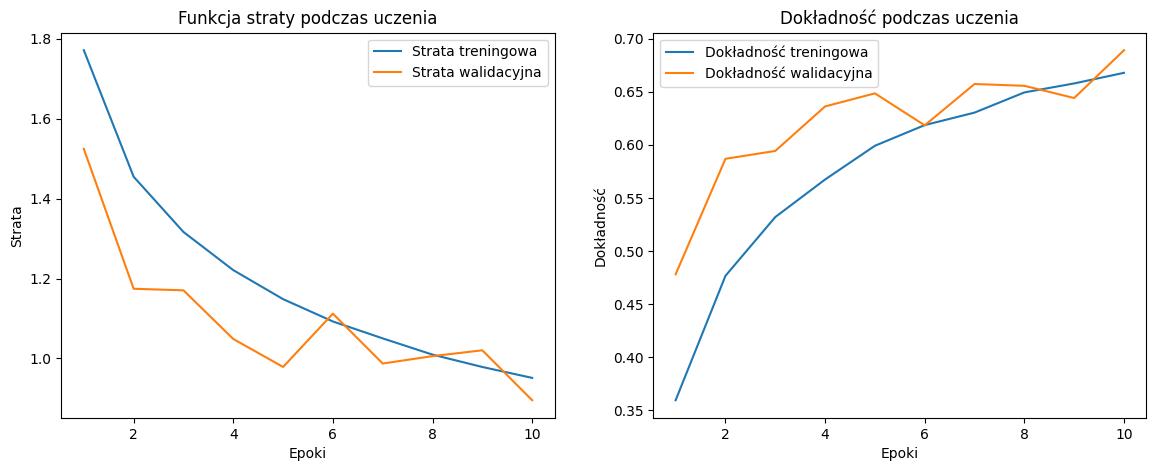

In [16]:
# Załaduj zbiór danych CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0  # Normalizacja pikseli

# Konwersja etykiet na wektory kategorii
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Przyrostowy model CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)), # 32 filtry 3x3 z funkcją aktywacji ReLU
    BatchNormalization(), # dla satbilizacji uczenia
    MaxPooling2D(pool_size=(2, 2)), # warstwa MaxPooling 2x2 - zmniejszenie rozmiaru mapy cech
    Dropout(0.25), # Dropout 25% - regularyzacja modelu, zapobieganie przeuczeniu
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(), # Spłaszczenie tensora do wektora
    Dense(128, activation='relu'), 
    Dropout(0.5),
    Dense(10, activation='softmax') # Warstwa wyjściowa z 10 neuronami (klasyfikacja 10 klas)
])

# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Trening modelu z zapisem historii
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Wizualizacja wyników uczenia
epochs = range(1, 11)

plt.figure(figsize=(14, 5))

# Wykres funkcji straty
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Strata treningowa')
plt.plot(epochs, history.history['val_loss'], label='Strata walidacyjna')
plt.title('Funkcja straty podczas uczenia')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

# Wykres dokładności
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Dokładność treningowa')
plt.plot(epochs, history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Dokładność podczas uczenia')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

plt.show()

### Zadanie 4

Różne tryby uczenia transferowego
- **Uczenie z zamrożeniem większości warstw**: Pozostawienie wag modelu bazowego bez zmian i dostosowanie ostatnich warstw.
- **Uczenie wszystkich warstw**: Odblokowanie wszystkich warstw do trenowania na nowych danych.
- **Feature extraction**: Wykorzystanie modelu do ekstrakcji cech bez ponownego treningu.

In [ ]:
# Wczytanie zbioru CIFAR-10 i przeskalowanie obrazów do 96x96 (mniejsze zużycie pamięci)
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = tf.image.resize(X_train, (96, 96)) / 255.0
X_test = tf.image.resize(X_test, (96, 96)) / 255.0
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Wyświetlenie liczby próbek
print(f"Liczba próbek treningowych: {X_train.shape[0]}")
print(f"Liczba próbek testowych: {X_test.shape[0]}")

# Wczytanie modelu MobileNetV2 z pretrenowanymi wagami i bez górnych warstw
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False  # Zamrożenie wag modelu bazowego

# Dodanie własnych warstw na końcu
model = Sequential([
    base_model,
    GlobalAveragePooling2D(), # Zmniejsza wymiary wyjściowe z warstw konwolucyjnych do jednowymiarowego wektora
    Dense(96, activation='relu'), # Warstwa gęsto połączona z 96 neuronami
    Dense(10, activation='softmax')  # 10 klas dla C IFAR-10
])

# Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu, optymalizator Adam i funkcja straty

# Trening modelu (zmniejszona liczba epok i batch_size dla szybszego działania)
history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test), verbose=1) # Trening modelu

# Wykres strat i dokładności
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()
plt.show()

Liczba próbek treningowych: 50000
Liczba próbek testowych: 10000
9406464/9406464 [==============================] - 1s 0us/step
Epoch 1/3
1563/1563 [==============================] - 100s 61ms/step - loss: 1.1233 - accuracy: 0.6111 - val_loss: 1.0066 - val_accuracy: 0.6465
Epoch 2/3
 885/1563 [===============>..............] - ETA: 42s - loss: 0.9015 - accuracy: 0.6841